# WikiRecentPhase2 - Master

## Streams processing + windowing

In [11]:
# Install components
!pip install sseclient
!pip install --user --upgrade streamsx

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: streamsx in /Users/siegenth/.local/lib/python3.5/site-packages (1.12.9)
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
# Setup 
import pandas as pd

from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

from statistics import mean
from collections import deque
from collections import Counter

import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline

from sseclient import SSEClient as EventSource

from ipywidgets import Button, HBox, VBox, Layout

from streamsx.topology.topology import *
import streamsx.rest as rest
from streamsx.topology import context


## Support functions for Jupyter

In [13]:
def catchInterrupt(func):
    """decorator : when interupt occurs the display is lost if you don't catch it
       TODO * <view>.stop_data_fetch()  # stop
       
    ."""
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt): pass
    return catch_interrupt

#
# Support for locating/rendering views.
def display_view_stop(eventView, period=2):
    """Wrapper for streamsx.rest_primitives.View.display() to have button. """
    button =  widgets.Button(description="Stop Updating")
    display(button)
    eventView.display(period=period) 
    def on_button_clicked(b):
        eventView.stop_data_fetch()
        b.description = "Stopped"
    button.on_click(on_button_clicked)

def view_events(views):
    """
    Build interface to display a list of views and 
    display view when selected from list.
     
    """
    view_names = [view.name for view in views]
    nameView = dict(zip(view_names, views))    
    select = widgets.RadioButtons(
        options = view_names,
        value = None,
        description = 'Select view to display',
        disabled = False
    )
    def on_change(b):
        if (b['name'] == 'label'):
            clear_output(wait=True)
            [view.stop_data_fetch() for view in views ]
            display(select)
            display_view_stop(nameView[b['new']], period=2)
    select.observe(on_change)
    display(select)

def find_job(instance, job_name=None):
    """locate job within instance"""
    for job in instance.get_jobs():    
        if job.applicationName.split("::")[-1] == job_name:
            return job
    else:
        return None

def display_views(instance, job_name):
    "Locate/promote and display all views of a job"
    job = find_job(instance, job_name=job_name)
    if job is None:
        print("Failed to locate job")
    else:
        views = job.get_views()
        view_events(views)

def list_cancel_jobs(_instance=None):
    """
    Interactive selection of jobs to cancel.
    
    Prompts with SelectMultiple widget, if thier are no jobs, your presente with a blank list.
    
    """
    active_jobs = { "{}:{}".format(job.name, job.health):job for job in _instance.get_jobs()}

    selectMultiple_jobs = widgets.SelectMultiple(
        options=active_jobs.keys(),
        value=[],
        rows=len(active_jobs),
        description="Select job(s) to cancel",
        layout=Layout(width='60%')
    )
    cancel_jobs = widgets.ToggleButton(
        value=False,
        description='Cancel',
        disabled=False,
        button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Delete selected jobs',
        icon="stop"
    )
    def on_value_change(change):
        for job in selectMultiple_jobs.value:
            print("canceling job:", job, active_jobs[job].cancel())
        cancel_jobs.disabled = True
        selectMultiple_jobs.disabled = True

    cancel_jobs.observe(on_value_change, names='value')

    return HBox([selectMultiple_jobs, cancel_jobs])

###  Support functions that are pushed to Streams

In [14]:
def get_events():
    """fetch recent changes from wikievents site using SSE"""
    for change in EventSource('https://stream.wikimedia.org/v2/stream/recentchange'):
        if len(change.data):
            try:
                obj = json.loads(change.data)
            except json.JSONDecodeError as err:
                print("JSON l1 error:", err, "Invalid JSON:", change.data)
            except json.decoder.JSONDecodeError as err:
                print("JSON l2 error:", err, "Invalid JSON:", change.data)
            else:
                yield(obj)


# Connect to the server :  ICP4D or Cloud instance. 
Attempt to import if fails the cfg will not be defined we know were using 
Cloud.

In [15]:
# ICP4D  - injected by 'Connected to instance' menu item
try:
    from icpd_core import icpd_util
    cfg = icpd_util.get_service_instance_details(name='sample-icp1')
    cfg[context.ConfigParams.SSL_VERIFY] = False
    instance = rest.Instance.of_service(cfg)
    print("Within ICP4D")
except ImportError:
    cfg = None
    print("Outside ICP4D")

Outside ICP4D


In [16]:
# disable 'InsecureRequestWarning'  - must be put after startup
if cfg is not None:
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [17]:
# NOT ICP4D : cloud access - 
if cfg is None:
    import credential   # remove @ ICP4D
    import common
    # TODO * check if instance is up
    # - link up to first cell (can you do a test and execute)
    sc = rest.StreamingAnalyticsConnection(service_name='Streaming3Turbine', vcap_services={'streaming-analytics':[{'name':'Streaming3Turbine','credentials':credential.streaming3Turbine}]})
    instance = sc.get_instances()[0]
    # Render the views.....

## List jobs and cancel....
This page will submit a job named 'WikiPhase1'. If it's running you'll want to cancel it before submitting a new version. If it is running, no need to cancel/submit you can just procede to the [Viewing data section](#viewingData).

In [18]:
list_cancel_jobs(instance)

HBox(children=(SelectMultiple(description='Select job(s) to cancel', layout=Layout(width='60%'), options=(), rows=0, value=()), ToggleButton(value=False, button_style='warning', description='Cancel', icon='stop', tooltip='Delete selected jobs')))

# Composing the Streams application
The following functions that will be executing within the deployed Streams application. 
The functions a [composed](#composeBuildSubmit) into an application that is compiled and submitted to the Streams instance.

## Receive messages updates from Wikipedia
As updates are made to Wikipidia pages the changs are sent over and SSE feed. The get_events() function recieves the events and acting as a [source](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Topology.source) pushes them onto the Streams stream.

In [19]:
def get_events():
    """fetch recent changes from wikievents site using SSE"""
    for change in EventSource('https://stream.wikimedia.org/v2/stream/recentchange'):
        if len(change.data):
            try:
                obj = json.loads(change.data)
            except json.JSONDecodeError as err:
                print("JSON l1 error:", err, "Invalid JSON:", change.data)
            except json.decoder.JSONDecodeError as err:
                print("JSON l2 error:", err, "Invalid JSON:", change.data)
            else:
                yield(obj)

## Aggregating tuples
The [aggregation](http://ibmstreams.github.io/streamsx.topology/doc/pythondoc/streamsx.topology.topology.html#streamsx.topology.topology.Window.aggregate) which is performed
accross a list of tuples. The list is defined by a [window](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Window) which can be count or timed based with 
various options. 
in general the function is invoked when the window's
critera are met. 

### Summing fields

In [ ]:
class sum_aggregate():
    def __init__(self, sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }):
        """
        Summation of column(s) over a window's list of objects. 
        On a windows list objects, perform summation on the summary_field, output to result_field
        """
        self.sum_map = sum_map
    def __call__(self, tuples):    
        summaries = dict()
        for summary_field,result_field in self.sum_map.items():
            summation = sum([ele[summary_field] for ele in tuples])
            summaries.update({result_field : summation})
        return(summaries)


Illustrating testing.

In [ ]:
verify = []
for idx in range(1,5): verify.append({ col:idx for col in ['new_len', 'old_len','delta_len','junk']})

sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }
s = sum_aggregate()
print("sum_aggregate", s.__call__(verify))

### Tallying fields

In [ ]:
import collections
class tally_fields(object):
    def __init__(self, top_count=3, fields=['user', 'wiki', 'title']):
        """
        Tally fields of a list of tuples, output the name and . 
        """
        self.fields = fields
        self.top_count = top_count
    def __call__(self, tuples)->list:
        tallies = dict()
        for field in self.fields:
            stage = [tuple[field] for tuple in tuples if tuple[field] is not None]
            tallies[field] = collections.Counter(stage).most_common(self.top_count)
        return tallies

Illustrating testing.

In [ ]:
# tally_fields
tst = [
   {'tst1':'a', 'tst2':'a', 'tst3':'a'},
   {'tst1':'a', 'tst2':'a', 'tst3':'a'},
   {'tst1':'b', 'tst2':'a', 'tst3':'b'},
   {'tst1':'b', 'tst2':'a', 'tst3':'a'},
   {'tst1':'b', 'tst2':'a', 'tst3':'a'},
   {'tst1':'b', 'tst2':'a', 'tst3':'a'},
]
tally = tally_fields(top_count=2, fields=['tst1','tst2','tst3'])
tsts = tally.__call__(tst)
print(tsts)
[{'field':tst,'value':tsts[tst]}for tst in tsts]


## Mapping tuples

The event's 'wiki' field is the database that events pertains to. The database has a primary language which muliple databases share a common language. We'll use aht wikimap.csv to reconcile the events message using the augment_lang
function using [map](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.map) to drive the processing.

When defining a class be aware that the __init__() is executed locally at compile invocation when the self value is pickeld. Before call is __call__() invoked at runtime the self is depickeled. In the augmentation_lang.__init__() code 
below, csv file is read into dict that maps from 'wiki' to 'language' and saved to *self*. At runtime the *self* with it's wiki/language mapping reconsile the language. 

In [ ]:
import csv
class wiki_lang():
    """
    Augment the tuple to include language a description of the wiki the 
    event is destined for. The entry is augmented with language, native and code. 
    
    Mapping is loaded at build time and utilized at runtime.
    """

    def __init__(self, fname="wikimap.csv"):
        self.wiki_map = dict()
        with open(fname, mode='r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                self.wiki_map[row['dbname']] = row

    def __call__(self, tuple):
        if tuple['wiki'] in self.wiki_map:
            key = tuple['wiki']
            tuple['code'] = self.wiki_map[key]['code']
            tuple['language'] = self.wiki_map[key]['in_english']
            tuple['native'] = self.wiki_map[key]['name_language']
        else:
            tuple['code'] = tuple['language'] = tuple['native'] = None
        return tuple


## Filter messages
The [filter](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.filter) is used to break out messages not generated by robots.

## View into the live stream
The [view](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.view) enables access to live stream at runtime. We spread them liberaly throughout the application to observe how the processing is procedeing

<a id='composeBuildSubmit'></a>
## Compose, build and submit the Streams application.

In [ ]:
def WikiPhase2(jobName=None, wiki_lang_fname=None):
    """
    Compose topology. 
    -- wiki_lang : csv file mapping database name to langauge

    """
    topo = Topology(name=jobName)
    ### make sure we sseclient in Streams environment.
    topo.add_pip_package('sseclient')
    
    ## wiki events
    source = topo.source(get_events, name="WikiFeed")
    ## select events generated by humans
    edits = source.filter(lambda x: x['type']=='edit' and x['bot'] is False, name='humanEdits')
    # pare down the humans set of columns
    paredEdits = edits.map(lambda x : {'timestamp':x['timestamp'],'new_len':x['length']['new'],'old_len':x['length']['old'], 'delta_len':x['length']['new'] - x['length']['old'],'wiki':x['wiki'],'user':x['user'],'title':x['title']}, 
                        name="selectMain")
    paredHumanEdits = paredEdits.view(buffer_time=1.0, sample_size=200, name="paredHumanEdits", description="Edits done by humans")

    ## Define window(count)& aggregate
    winAgg = paredEdits.last(100).trigger(20)
    sumAggregate_ = winAgg.aggregate(sum_aggregate(sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }), name="sumAggregate")
    aggEdits = sumAggregate_.view(buffer_time=1.0, sample_size=200, name="aggEdits", description="Aggregations of human edits")

    ## Define window(count) & tally edits
    tallyWin = paredEdits.last(100).trigger(10)
    tallyTop = tallyWin.aggregate(tally_fields(fields=['user', 'title'], top_count=10), name="talliesTop")
    talliesCount = tallyTop.view(buffer_time=1.0, sample_size=200, name="talliesCount", description="Top count tallies: user,titles")

    ## augment filterd/pared edits with language

    langAugment = paredEdits.map(wiki_lang(fname=wiki_lang_fname), name="langAugment")
    langAugment.view(buffer_time=1.0, sample_size=200, name="langAugment", description="Language derived from wiki")

    ## Define window(time) & tally language
    timeLangWin = langAugment.last(datetime.timedelta(minutes=2)).trigger(5)
    timeLanguage = timeLangWin.aggregate(tally_fields(fields=['language'], top_count=10), name="timeLang")
    talliesTime = timeLanguage.view(buffer_time=1.0, sample_size=200, name="talliesTime", description="Top timed tallies: language")
   
    timeLanguage.print(name="printMinLang")
    return ({"topo":topo,"view":{ }})



## Submitting job : ICP or Cloud

In [ ]:
## ICP4D submission
from streamsx.topology import context
from streamsx.topology.topology import Topology

#cfg=icpd_util.get_service_instance_details(name='sample-icp1')
if cfg is not None:
    resp = WikiPhase2(jobName="WikiPhase2", wiki_lang_fname=os.environ['DSX_PROJECT_DIR']+'/datasets/wikimap.csv')
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False

    submission_result = context.submit("DISTRIBUTED",
                                   resp['topo'], 
                                   config=cfg)
    # The submission_result object contains information about the running application, or job
    if submission_result.job:
        print("JobId: ", submission_result['id'] , "Name: ", submission_result['name'])


In [ ]:
## Cloud submission
if cfg is None:
    resp = WikiPhase2(jobName="WikiPhase2", wiki_lang_fname="wikimap.csv")
    submitStatus = common.submitProcess(topology=resp['topo'],
                                        streamsService="Streaming3Turbine",
                                        buildType="DISTRIBUTED",
                                        serviceType="STREAMING_ANALYTIC",
                                        jobName="WikiPhase2",
                                        cancel=True)

## What does the application look like.....

Graph of application running, since we're using live data the values on the edges between the nodes
will be different but the nodes should be the same. Notice that the count of tuples input port of botFilter is 
diffent from the output port, only tuples match the critera appear on the output port.

**TO Decide**

The graph should stay but do not the idea of telling someone how to access the console has been squashed, do
not show things that are not 'blessed'

I can make this into a multipart gif, which gives a better idea of what is going on. But, not having a the console that they can go to see the live may not be a good idea.

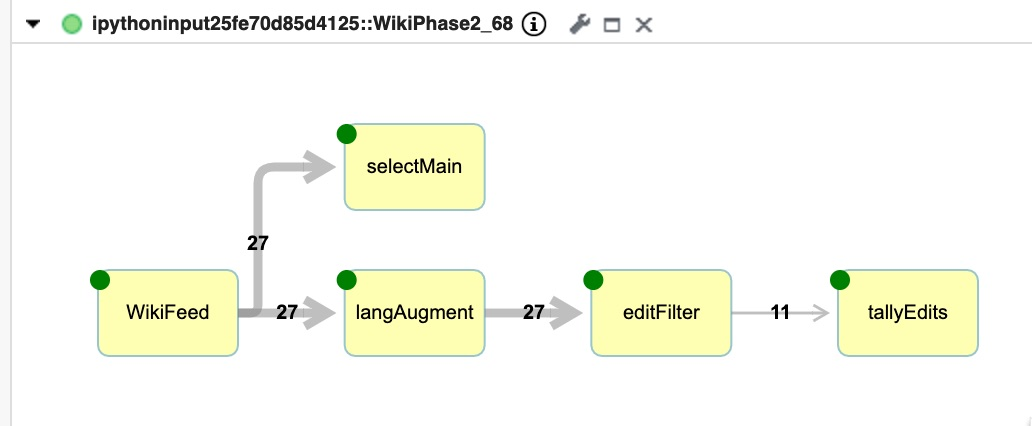

<a id='viewingData'></a>
## Viewing data 

The running application has number of views to see what what data is moving through the stream. The following 
cell will fetch the views' queue and dipslay it's data when selected. 

|view name | description of data is the view |
|---------|-------------|
|aggEdits  | summarised fields 'bot' is **False** |
|langAugment | mapped augmented fields 'bot' is **False** |
|paredHumanEdits | seleted fields,  'bot' is **False** |
|talliesCount | last 100 messages tallied 'bot' is **False**|
|talliesTimes | 2 minute windowed 'bot' is **False**|


You want to stop the the fetching the view data when done.


## Acces Views / Render Views UI

In [ ]:
# Render the views.....
display_views(instance, job_name="WikiPhase2")

# Server side
- can you generate timeseries on the server side and push to the client
- what would you get. 

## rendering : tally_pie 

In [ ]:
@catchInterrupt
def tally_pie(view=None, tally_field='language'):
    idx = 0
    while (True):
        idx += 1
        tuples = view.fetch_tuples(max_tuples=10, timeout=10 )
        language= [lst[0] for lst in tuples[-1][tally_field]]
        counts = [lst[-1] for lst in tuples[-1][tally_field]]
        percent = counts[0]/sum(counts) * 100
        print("[{2}]{0:4.2f}% of the events are in {1}, {1} will be dropped from the piechart.".format(percent,language[0],"+*"[idx%2]))
        df = pd.DataFrame({'counts': counts[1:]}, index=language[1:])
        df.plot.pie(y='counts')    
        plt.show()
        clear_output(wait=True)

## talliesTime : Language activity in pie chart  / window:time

In [ ]:
view = instance.get_views(name="talliesTime")[0]
view.start_data_fetch()
tally_pie(view, tally_field='language')

##  rendering : tally_table

In [ ]:
@catchInterrupt
def tally_table(tally_field="title"):
    while True:
        tallies = view.fetch_tuples(max_tuples=100, timeout=2)
        if tallies is not None and len(tallies) != 0:
            title_tallies = tallies[0][tally_field]
            title = [ele[0] for ele in title_tallies]
            count = [ele[1] for ele in title_tallies]
            tbl = [(tally_field, title),('count', count)]
            df = pd.DataFrame.from_items(tbl)
            display(df)
            clear_output(wait=True)
        else:
            display("Fetch Fail")

### top users / window:count

In [ ]:
view = instance.get_views(name="talliesCount")[0]
view.start_data_fetch()
tally_table(tally_field="user")

### top / titles window:count


In [ ]:
view = instance.get_views(name="talliesCount")[0]
view.start_data_fetch()
tally_table(tally_field="title")

## view.stop_data_fetch()